## Hierarchical Modeling
What models fit the data?

In [1]:
import scipy
import pandas as pd
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import warnings
import matplotlib.gridspec as gridspec

import seaborn as sns




#### Parameters

In [2]:
config = {
    "bins": 16,
    "min_bin_percentile": 10,
}

#### Load data

In [3]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

,density,edginess,references,citations_per_year,is_center,identifier,year,librarian,vectorizer,center,fields_of_study_0
0,1545.550332,0.814415,42,2.250000,False,2e5f3e6c87d1676cdeffc3a2bfbc30b6cd06ed6f,2004,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
1,1846.261870,0.452021,88,4.625000,False,d7b6cd39dd111afa55a3aa418b7b5459db12988d,2012,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
2,1703.520959,0.490212,30,0.882353,False,2d62ec65f95435c72ef750b3cff331382c5dca92,2003,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
3,1901.386693,0.715160,95,8.166667,False,8cebc6e3dcfb543bad48d89112e281a6e11c33c2,2014,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
4,535.472125,0.885892,94,2.090909,False,59730a4bae4dc53f59341b63fd1e63451c589e9f,2009,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
...,...,...,...,...,...,...,...,...,...,...,...
537685,48.730838,0.658585,41,3.500000,False,806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24,2018,S2,SciBERT,Andre2018,Mathematics
537686,25.107589,0.721374,38,3.200000,False,f40707d1165c22e185c25e6837977177ee380f2c,2015,S2,SciBERT,Andre2018,Mathematics
537687,41.647954,0.646499,11,1.529412,False,10636ee16779a7521001651164acb5c192d4ad7b,2003,S2,SciBERT,Andre2018,Mathematics
537688,35.738649,0.708053,15,2.384615,False,a229f829e0a5362d00e63781f687f40ede991635,2007,S2,SciBERT,Andre2018,Mathematics


In [4]:
# Basic nan handling across all obs
df_all["log_cpy"] = np.log10(df_all["citations_per_year"])
df_all['log_cpy'] = df_all['log_cpy'].replace(-np.inf, np.nan)

In [5]:
field_names = sorted(df_all["fields_of_study_0"].unique())
field_names

['Economics',
 'Education',
 'Geology',
 'Linguistics',
 'Materials Science',
 'Mathematics',
 'Medicine',
 'Philosophy',
 'Physics']

In [6]:
vectorizer_names = sorted(df_all["vectorizer"].unique())
vectorizer_names

['BOW', 'GPT2', 'SBERT', 'SciBERT', 'Word2Vec']

# Plot

### Brief aside on logscale plotting

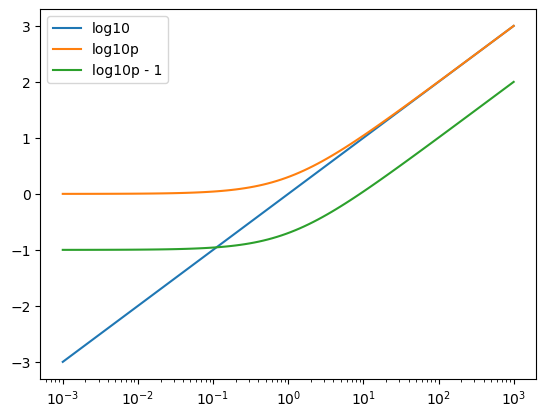

In [7]:
fig = plt.figure()
ax = plt.gca()

x = np.logspace(-3, 3, 100)
log10 = np.log10(x)
log10p = np.log10(1 + x)
log10p2 = np.log10(1 + x) - 1

ax.plot(
    x,
    log10,
    label="log10",
)
ax.plot(
    x,
    log10p,
    label="log10p",
)
ax.plot(
    x,
    log10p2,
    label="log10p - 1",
)

ax.legend()

ax.set_xscale("log")

### Overview Normalized 2D Histogram

In [8]:
def get_bins(x, n_bins=config["bins"]):
    # Get density bins
    bins = np.linspace(
        np.nanpercentile(x, config["min_bin_percentile"]),
        np.nanpercentile(x, 100 - config["min_bin_percentile"]),
        n_bins + 1,
    )
    return bins


density_bins = df_all.groupby("vectorizer")["density"].apply(get_bins).to_dict()
cpy_bins = get_bins(
    df_all["log_cpy"], n_bins=17
)  # The n_bins=17 is to ensure we don't accidentally flip axes

In [9]:
def custom_histplot(data, x, y, normed=True, *args, **kwargs):

    # Get the appropriate facets
    vectorizer = data["vectorizer"].unique()[0]
    field = data["fields_of_study_0"].unique()[0]

    density_bins = get_bins(data[x])

    if normed:
        hist2d, _, _ = np.histogram2d(data[x], data[y], bins=(density_bins, cpy_bins))
        density_hist, _ = np.histogram(data[x], bins=density_bins)
        hist2d_normed = hist2d / density_hist.reshape(1, -1).T

        # Plot the data
        plt.pcolormesh(
            density_bins,
            cpy_bins,
            hist2d_normed.T,
            shading='auto',
            cmap="viridis",
        )
    else:
        sns.histplot(data, x=x, y=y, bins=(density_bins, cpy_bins), *args, **kwargs)

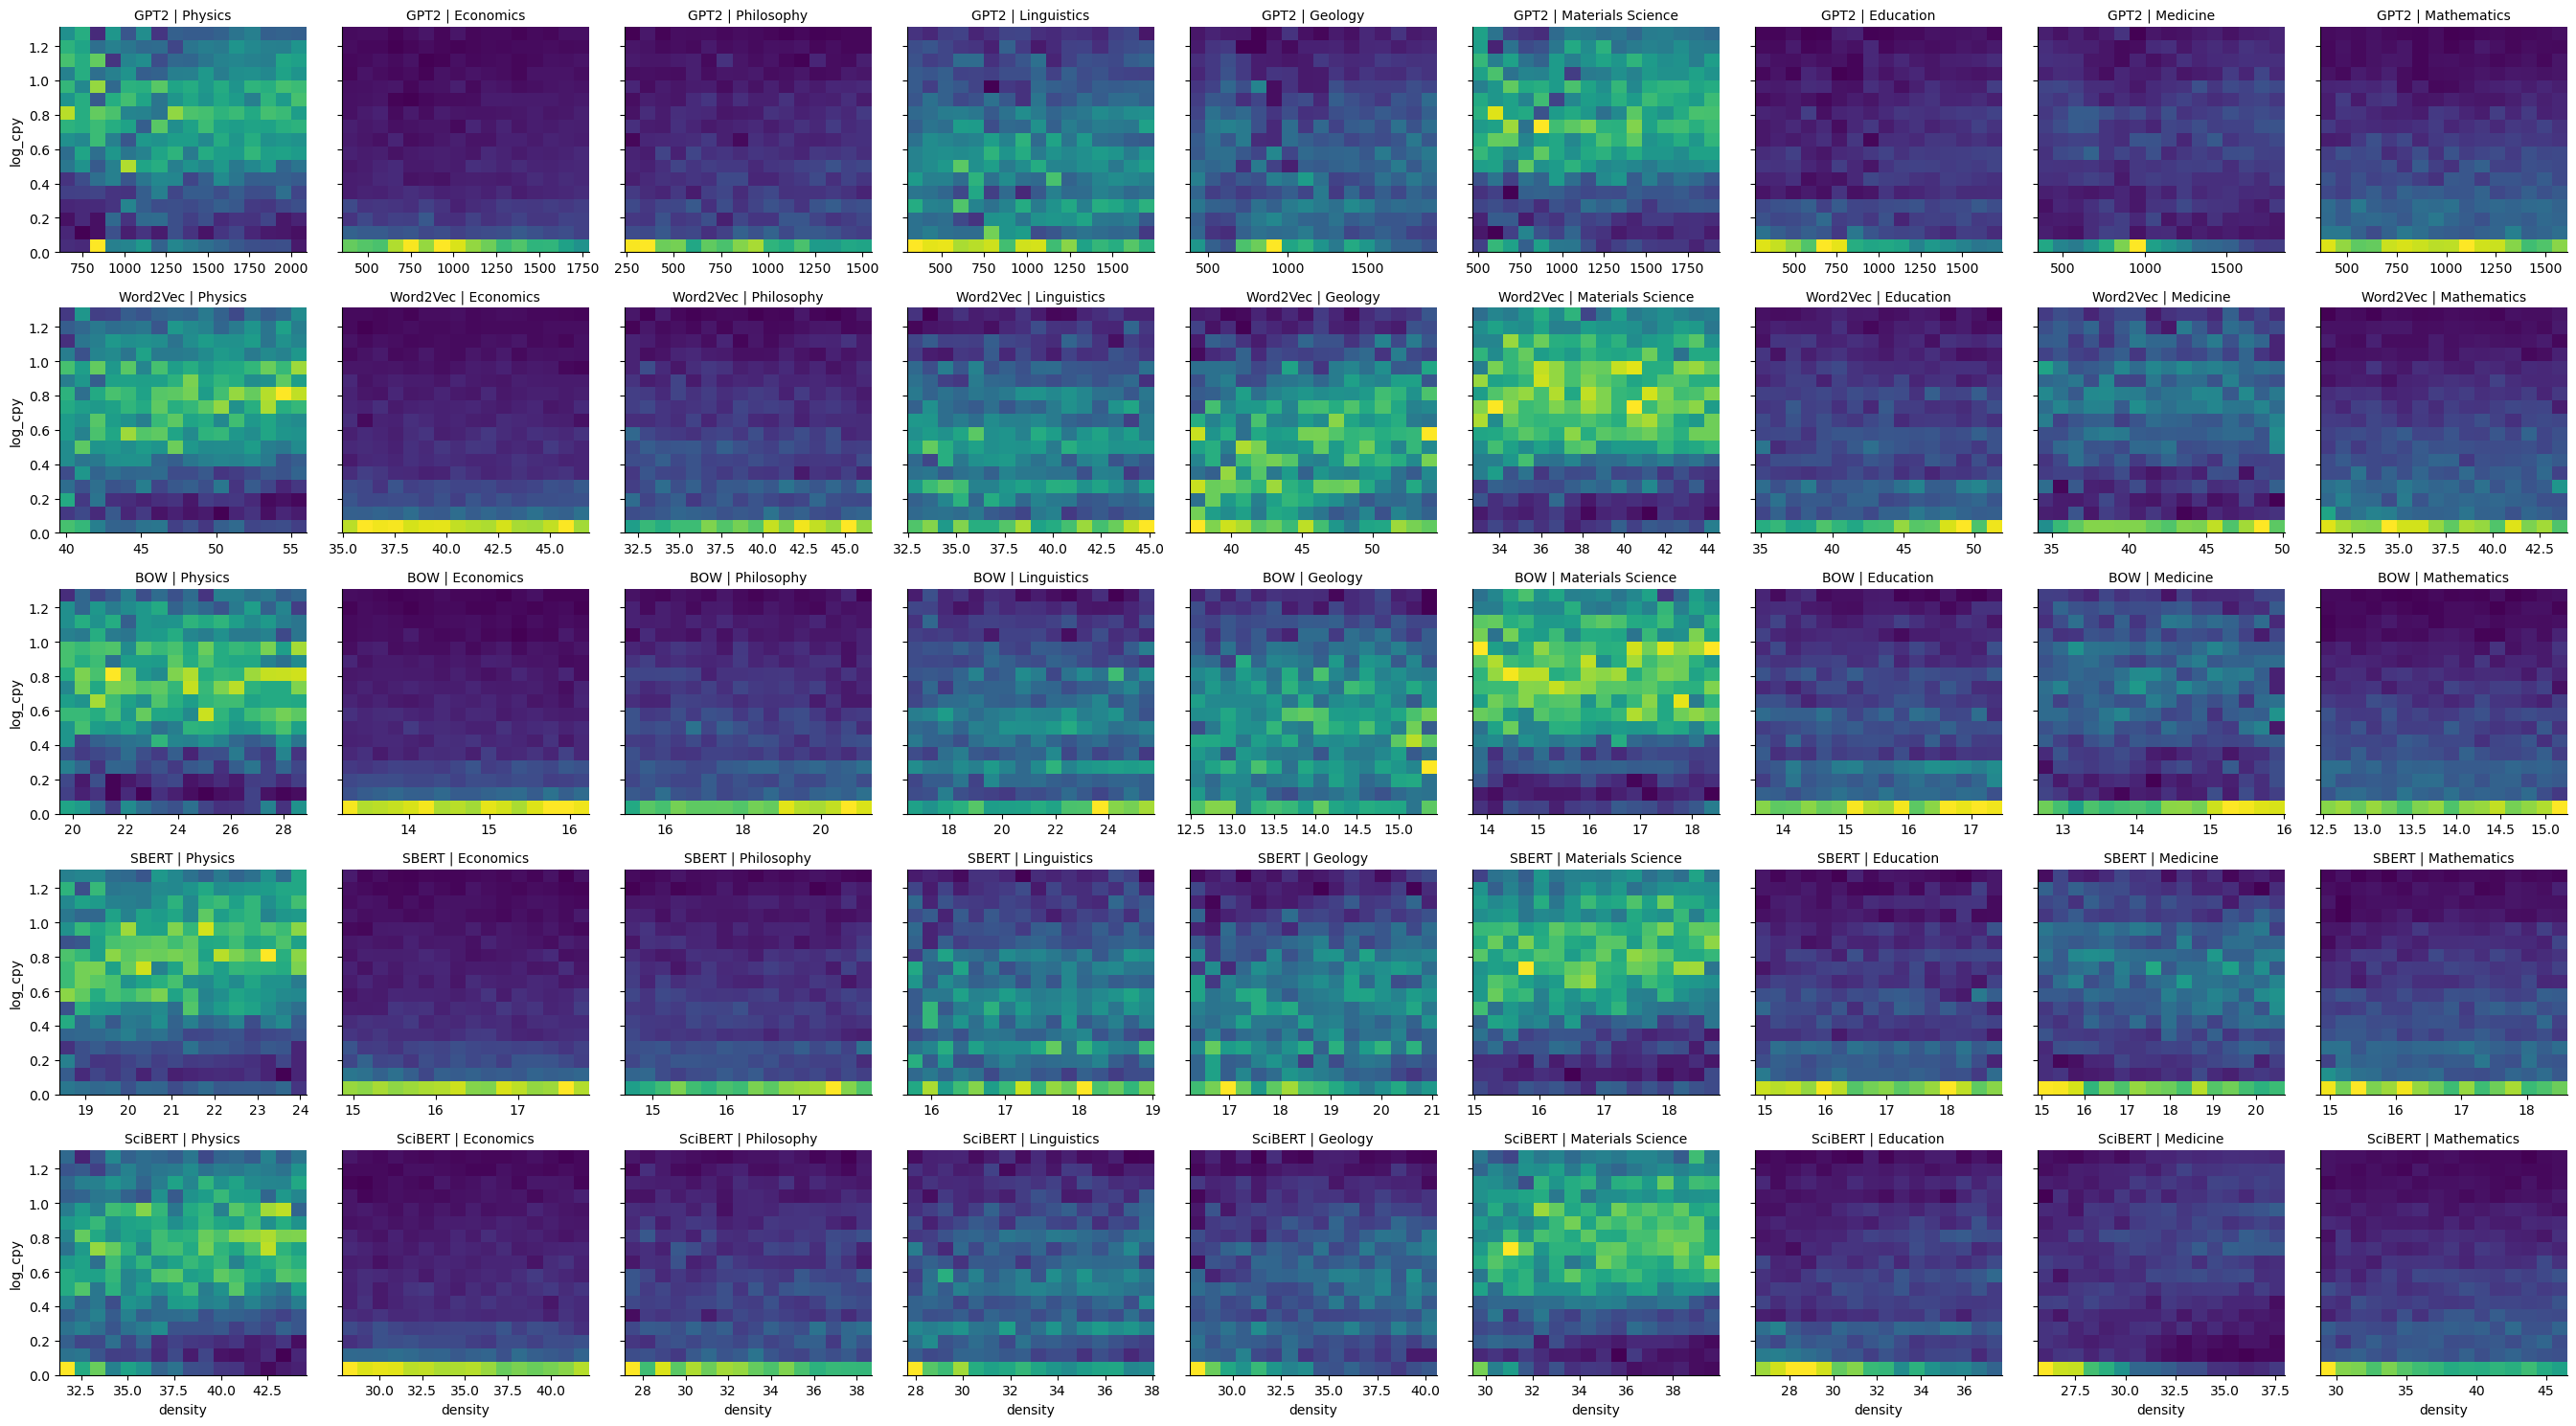

In [10]:
fg = sns.FacetGrid(data=df_all, row="vectorizer", col="fields_of_study_0", sharex=False)
fg.map_dataframe(custom_histplot, x="density", y="log_cpy", normed=True)
fg.set_titles("{row_name} | {col_name}")